In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch

In [3]:
import matplotlib.pyplot as plt

In [4]:
CONFIDENCE = 0.5
SCORE_THRESHOLD = 0.5
IOU_THRESHOLD = 0.5

In [5]:
config_path = "yolov2-tiny.cfg"
weights_path = "yolov2-tiny.weights"
labels = open("coco.names").read().strip().split("\n")
colors = np.random.randint(0, 255, size=(len(labels), 3), dtype="uint8")

In [6]:
net = cv2.dnn.readNetFromDarknet(config_path, weights_path)

In [7]:
path_name = "karavan28.jpg"
image = cv2.imread(path_name)

In [8]:
image.shape

(664, 1000, 3)

In [9]:
def intersection_over_union(boxes_preds, boxes_real, type='corners', unsqueeze=False):

    boxes_preds = torch.tensor(boxes_preds)
    boxes_real = torch.tensor(boxes_real)
    if unsqueeze:
        boxes_preds = boxes_preds.unsqueeze(0)
        boxes_real = boxes_real.unsqueeze(0)
    if type == 'corners':
        box1_x1, box1_y1, box1_x2, box1_y2 = boxes_preds[..., 0], boxes_preds[..., 1], boxes_preds[..., 2], boxes_preds[..., 3]
        box2_x1, box2_y1, box2_x2, box2_y2 = boxes_real[..., 0], boxes_real[..., 1], boxes_real[..., 2], boxes_real[..., 3]

    else:
        box1_xc, box1_yc, box1_w, box1_h = boxes_preds[..., 0], boxes_preds[..., 1], boxes_preds[..., 2], boxes_preds[..., 3]
        box2_xc, box2_yc, box2_w, box2_h = boxes_real[..., 0], boxes_real[..., 1], boxes_real[..., 2], boxes_real[..., 3]

        box1_x1, box1_y1, box1_x2, box1_y2 = (box1_xc - box1_w / 2, box1_yc - box1_h / 2,
                                              box1_xc + box1_w / 2, box1_yc + box1_h / 2)

        box2_x1, box2_y1, box2_x2, box2_y2 = (box2_xc - box2_w / 2, box2_yc - box2_h / 2,
                                              box2_xc + box2_w / 2, box2_yc + box2_h / 2)

    x1 = torch.max(box1_x1, box2_x1)
    x2 = torch.min(box1_x2, box2_x2)
    y1 = torch.max(box1_y1, box2_y1)
    y2 = torch.min(box1_y2, box2_y2)

    area1 = abs(box1_x2 - box1_x1) * abs(box1_y2 - box1_y1)
    area2 = abs(box2_x2 - box2_x1) * abs(box2_y2 - box2_y1)
    intersection = (x2-x1).clamp(0) * (y2-y1).clamp(0)

    return (intersection / (area2+area1-intersection)).numpy()


In [10]:
intersection_over_union([0, 0, 1, 1], [0, 0, 2, 1]).item()

0.5

In [11]:
def trecking(prev_objects, prev_boxes, prev_name, next_object, next_boxes):
    next_name = []
    for i in range(len(prev_objects)):
        for j in range(len(next_object)):
            if intersection_over_union(prev_boxes[i], next_boxes[j]).item()>=0.5 and prev_objects[i]==next_object[j]:
                next_name.append(prev_name[i])
            else:
                next_name.append(len(prev_name))
    if len(next_name)==0 and len(next_object)!=0:
        next_name+=list(range(len(next_object)))
    return next_name

In [12]:
trecking([0], [[0, 0, 1, 1]], [0], [0], [[0, 0, 2, 1]])

[0]

In [13]:
def put_bboxes(image, prev_objects, prev_boxes, prev_names):
    h, w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in [net.getUnconnectedOutLayers()]]
    layer_outputs = net.forward(ln)
    font_scale = 2
    thickness = 2
    boxes, confidences, class_ids = [], [], []
    for output in layer_outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > CONFIDENCE:
                box = detection[:4] * np.array([w, h, w, h])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    next_names = trecking(prev_objects, prev_boxes, prev_names, class_ids, boxes)
    if len(boxes)!=0:
        for i in range(len(boxes)):
            x, y = boxes[i][0], boxes[i][1]
            w, h = boxes[i][2], boxes[i][3]
            color = [int(c) for c in colors[class_ids[i]]]
            cv2.rectangle(image, (x, y), (x + w, y + h), color=color, thickness=thickness)
            text = f"{labels[class_ids[i]]} {next_names[i]}: {confidences[i]:.2f}"
            (text_width, text_height) = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, fontScale=font_scale, thickness=thickness)[0]
            text_offset_x = x
            text_offset_y = y - 5
            box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height))
            overlay = image.copy()
            cv2.rectangle(overlay, box_coords[0], box_coords[1], color=color, thickness=cv2.FILLED)
            image = cv2.addWeighted(overlay, 0.6, image, 0.4, 0)
            cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=font_scale, color=(0, 0, 0), thickness=thickness)
    print(boxes, confidences, class_ids)
    return image

In [14]:
import time

In [15]:
cap = cv2.VideoCapture(0)
time.sleep(0.1)
ret, img = cap.read()
cap.release()

In [16]:
cap = cv2.VideoCapture(0)
time.sleep(1)
while True:
    ret, img = cap.read()
    cv2.imshow("camera", put_bboxes(img, [], [], []))
    if cv2.waitKey(10) == 27: # Клавиша Esc
        break
cap.release()
cv2.destroyAllWindows()

[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[[148, 174, 985, 587]] [0.626021683216095] [0]
[] [] []
[[194, 175, 894, 583]] [0.6121262907981873] [0]
[[158, 195, 949, 555]] [0.6539812684059143] [0]
[[156, 180, 960, 581]] [0.6298199892044067] [0]
[[166, 190, 933, 559]] [0.6909928321838379] [0]
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[] [] []
[[131, 201, 805, 533]] [0.7319440841674805] [0]
[] [] []
[[105, 187, 862, 558]] [0.6225617527961731] [0]
[[166, 186, 936, 570]] [0.638529896736145] [0]
[[194, 187, 877, 569]] [0.6992365

In [17]:
cv2.imshow('oihih', put_bboxes(img))

[[321, 169, 830, 589]] [0.6178419589996338] [0]


In [10]:
cap = cv2.VideoCapture(0)
time.sleep(1)
while True:
    ret, img = cap.read()
    cv2.imshow("camera", put_bboxes(img))
    if cv2.waitKey(10) == 27: # Клавиша Esc
        break
cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/highgui/src/window.cpp:1000: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'imshow'


In [15]:
cap.release()

In [9]:
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in [net.getUnconnectedOutLayers()]]

In [10]:
layer_outputs = net.forward(ln)

In [11]:
font_scale = 2
thickness = 2
boxes, confidences, class_ids = [], [], []
for output in layer_outputs:
    for detection in output:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > CONFIDENCE:
            box = detection[:4] * np.array([w, h, w, h])
            (centerX, centerY, width, height) = box.astype("int")
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            class_ids.append(class_id)

In [12]:
for i in range(len(boxes)):
    x, y = boxes[i][0], boxes[i][1]
    w, h = boxes[i][2], boxes[i][3]
    color = [int(c) for c in colors[class_ids[i]]]
    cv2.rectangle(image, (x, y), (x + w, y + h), color=color, thickness=thickness)
    text = f"{labels[class_ids[i]]}: {confidences[i]:.2f}"
    (text_width, text_height) = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, fontScale=font_scale, thickness=thickness)[0]
    text_offset_x = x
    text_offset_y = y - 5
    box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height))
    overlay = image.copy()
    cv2.rectangle(overlay, box_coords[0], box_coords[1], color=color, thickness=cv2.FILLED)
    image = cv2.addWeighted(overlay, 0.6, image, 0.4, 0)
    cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=font_scale, color=(0, 0, 0), thickness=thickness)

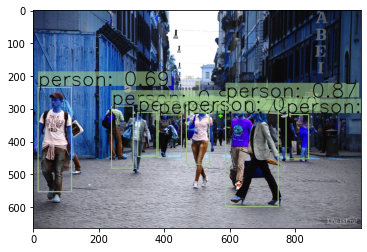

In [14]:
plt.imshow(image)

In [ ]:
Ч